In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import config as cfg
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import DBSCAN

sys.path.append(r"C:\Users\safou\OneDrive\Bureau\iridia-af-main\iridia_af")

import hyperparameters as hp
from record import Record

In [2]:
dataset_path = Path(hp.DATASET_PATH, f"dataset_hrv_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
print(dataset)

          mean_nni       sdnn       sdsd  nni_50    pnni_50  nni_20  \
0       764.133333  94.663630  35.918720      19   6.354515      65   
1       722.841667  50.851322  33.526178      17   5.685619      71   
2       714.025000  48.283100  38.653695      22   7.357860      89   
3       726.450000  59.291927  39.320096      32  10.702341     100   
4       738.900000  58.737754  44.043039      37  12.374582     120   
...            ...        ...        ...     ...        ...     ...   
310770  481.375000  80.907562  76.027531     165  55.183946     249   
310771  477.458333  82.742614  78.727349     167  55.852843     245   
310772  481.133333  93.300270  85.324228     174  58.193980     248   
310773  481.866667  91.585207  84.588491     167  55.852843     244   
310774  485.766667  96.109933  85.870391     180  60.200669     245   

          pnni_20      rmssd  median_nni  range_nni  ...       hfnu  \
0       21.739130  35.930070      745.00      695.0  ...  26.632166   
1    

In [3]:
df_af = dataset[dataset['label'] == 1]
X = df_af.drop(columns=["label", "patient", "record"]) # Exclude non-feature columns
y = df_af["label"]

In [4]:
input_dim = X.shape[1]  # Number of features in your dataset
encoding_dim = 8  # Dimension of the latent space 

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

In [5]:
history = autoencoder.fit(
    X, X,
    epochs=100,  # Experiment with the number of epochs
    batch_size=32,  # Adjust based on dataset size
    validation_split=0.2,  # Validation data for monitoring overfitting
    shuffle=True
)

Epoch 1/100
2355/2355 [==============================] - 9s 2ms/step - loss: 12296746.0000 - val_loss: 18834892.0000
Epoch 2/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296703.0000 - val_loss: 18834892.0000
Epoch 3/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296693.0000 - val_loss: 18834892.0000
Epoch 4/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296717.0000 - val_loss: 18834892.0000
Epoch 5/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296709.0000 - val_loss: 18834892.0000
Epoch 6/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296703.0000 - val_loss: 18834892.0000
Epoch 7/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296717.0000 - val_loss: 18834892.0000
Epoch 8/100
2355/2355 [==============================] - 3s 1ms/step - loss: 12296717.0000 - val_loss: 18834892.0000
Epoch 9/100
2355/2355 [==============================] - 3s 1ms/

In [6]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=1).output)
X_encoded = encoder.predict(X)


2944/2944 [==============================] - 3s 878us/step


In [7]:
# Initialize DBSCAN
eps_value = 0.5  # 
min_samples_value = 5  # Typically set between 5-10 (tune based on dataset size)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(X_encoded)

In [8]:
print(X_encoded.shape)

(94178, 8)


(94178, 2)


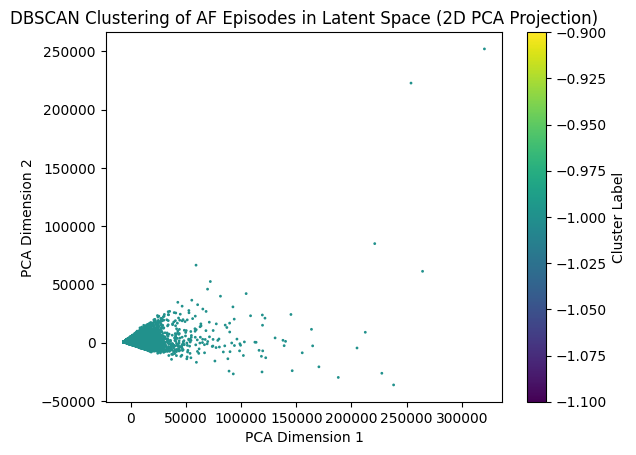

In [10]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_encoded_2d = pca.fit_transform(X_encoded)
print(X_encoded_2d.shape)
plt.scatter(X_encoded_2d[:, 0], X_encoded_2d[:, 1], c=clusters, cmap='viridis', s=1)
plt.colorbar(label='Cluster Label')
plt.title("DBSCAN Clustering of AF Episodes in Latent Space (2D PCA Projection)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()